## Voronoi foam project

This is an implementation of part of the oronoi foam technology described in Procedural Voronoi Foams for Additive Manufacturing (Martinez et al. 2016).

The algorithms in the paper are designed for a GPU, whereas this is a Python implementation that doesn't take advantage of parallelization.


###### Let's perform some setup:
For all our examples, we are going to create a Voronoi Foam within the `bounds` (0 to 10 in all 3 dimensions).

With a density that increases as x increases (given by `density_func`) with a lower bound of at least 1 Voronoi seed point in each 4x4x4 cell (defined by `coarse_level_length`).

The beam radius of our foam is given to us by `tau`, and our voxels are 0.05x0.05x0.05 (`voxel_size`) in the final foam.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import numpy as np
from helpers import *

bounds = [0,0,0,10,10,10]
extent = np.array(bounds[3:6], dtype=float) - bounds[0:3]
coarse_level_length = 4.0
tau = 0.5 # beam radius
voxel_size=0.05

def density_func(point):
    # grading in x direction
    seed_density_factor = 1
    return (point[0] / extent[0]) * seed_density_factor  # seeds / mm^2


### Let us see how the Voronoi seeds in each cell are generated:


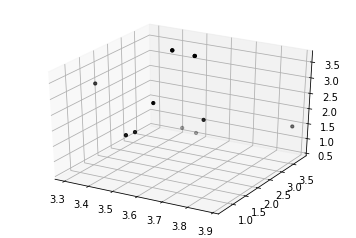

In [2]:
from subdivide_cell import subdivide_cell
cell_center = [2,2,2]
seeds = subdivide_cell(cell_center, coarse_level_length, density_func)
plot_seeds(seeds, seed_size=10)

### Gathering seeds that influence a point:
It is great that we can find seeds in a certain cell, but what is more important is gathering seeds that could influence a point in our foam.

This gathers all the seeds that could possibly effect the query point.

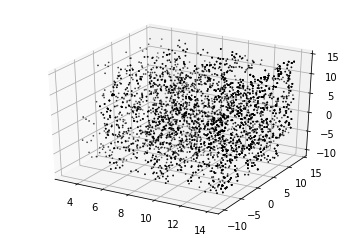

In [3]:
from gather_seeds import *
query_point = [2,2,2]
seeds=gather_seeds(query_point, coarse_level_length, density_func)
plot_seeds(seeds)

Sometimes we might want to gather the seeds that could influence points in our foam in the entire bounds:

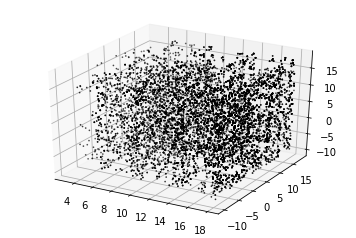

In [4]:
from gather_seeds import *
seeds=gather_seeds_for_bounds(bounds, coarse_level_length, density_func)
plot_seeds(seeds)

`gather_seeds_for_bounds` gathers seeds within 2 `coarse_level_length`s of the bounds.

This is slightly different than `gather_seeds` as described in the paper, which gathers the two ring neighborhood of the voronoi seed closest to the `query_point` (and the two ring neighborhood around q),
but I'm reasonably confident that this doesn't have an impact on a foam generated within the bounds.



### Determining if a point is in the foam:
All of the previous parts have been building up to figuring out whether or not a point is in the foam.

We do that here for a single point:

In [5]:
from eval_structure import eval_structure
query_point = [2,2,2]
result = eval_structure(query_point,coarse_level_length, tau, density_func)

if(result != 0):
    print("Point is filled in")
else:
    print("Query point not part of the Voronoi foam")

Query point not part of the Voronoi foam


In [ ]:
import timeit
def d_func(point):
    return 0
def to_time():
    from eval_structure import eval_structure
    eval_structure([1,1,1],coarse_level_length, 0.2, density_func)
timeit.timeit(to_time, number=1)

##### Timing analysis
Well, that took a while...

Let's figure out why.

A while ago, I performed a profile of a few calls to `eval_structure` with `cProfile`. Here are the (abreviated) results. Notably, the area around this query point has a minimal density.

Each line is time (in seconds) and function call.
```
    8.751 eval_structure.py:5(eval_structure)
        3.599 helpers.py:43(bisector_line)
            0.645 linalg.py:1976(norm) <- Several places: bisector line and line 28 of eval_structure
        1.067 helpers.py:35(distance)   <- in closest_seed and eval_structure
        3.303 gather_seeds.py:7(gather_seeds)
            3.006 subdivide_cell.py:31(subdivide_cell)
                0.967 subdivide_cell.py:26(random_permutation)
                    0.938 random.py:258(shuffle)
                0.392 subdivide_cell.py:19(random_sample_in_subcell)
                0.511 subdivide_cell.py:46(<listcomp>)
                0.308 random.py:93(seed)
            0.803 helpers.py:57(closest_point)
            0.737 subdivide_cell.py:5(gen_subcells)
```

##### Timing analysis cont.
This is spending about half the time in `gather_seeds` and the other half in `bisector_line`. So what do each of these do?

The code for `eval_structure` performs the operations something like this:

1. Gather all seeds and sort them by distance to the `query_point`
2. For each pair of seeds and the closest seed
    - Find the bisector line between these three cells
    - Does the line come within `tau` of the `query_point`?
    - if Yes:
        - Check if any other seed would invalidate the bisector line


`gather_seeds` is most of the first step of the algorithm and is relatively expensive, but it scales surprisingly well with increasing the density of the foam, with a set number of calls to `subdivide_cell`, which has a run time of $O(n_{density} \log(n_{density}))$

`bisector_line` performs a simple operation - most of it's time is taken up with performing a cross product to find the bisecting line's slope. This means it should run really fast.
But it is called once for each pair of seeds, which makes the loops it is in run in roughly $O(n_{density}^2)$.

One would think that most internal loop (checking if other seeds invalidate the bisector line) should dominate our time, but the bisector line is so rarely close to the query point that it doesn't effect the full time much.


##### Why is $O(n_{density}^2)$ bad?
The original paper neglected density and just considered the density as a constant term for querying a point. That is all well and good, but this implementation running on Python is significantly slower than what they were using, and $n_{density}$ is a high number - a two ring neighborhood around a point has 125 cells, each of which must have at least one Voronoi seed. $O(125^2)$ doesn't seem like such a small number.

We also need querying a single point to be really fast to calculate our foam quickly - we do it to every point in our voxel grid, which means we query 1000s of points for every z-level we print.

##### Why wasn't this a problem in the original implementation
In the original paper, they were able to do 1000s of points in less than a tenth of a second using this algorithm by leveraging a GPU.
This algorithm is perfect for a GPU - it is incredibly parallelizable (each point can be computed separately), so that if `eval_structure` runs in a tenth of a second (in a compiled language on a GPU, which is much faster than Python), each point can be processed in parallel and the result can be given in little over 0.1 seconds.




### Querying points faster:
Querying each point separately creates a lot of duplicate operations, re-generating each seed for all the voxels it could possibly effect, recomputing the bisector line, and more.

We could save a lot of time by finding those lines via a traditional (3D) Voronoi diagram algorithm and then plotting those.

Fortunately, `scipy` has an implementation of Voronoi diagrams. `scipy.spatial.Voronoi` actually uses a library called [Qhull](http://www.qhull.org) written in C/C++.

In [ ]:
from draw_voronoi import *

seeds = gather_seeds_for_bounds(bounds, coarse_level_length, density_func)
vor = Voronoi(seeds)

It is relatively simple to draw a 2D cross section of the Voronoi foam - it is mostly ellipses drawn onto a rectangle.

I draw all the cylindrical beams' intersections onto a cross section as ellipses, which is not entirely correct for beams that end within the cross section, and could cause junctions to be too thin to print, but it gets the idea across.

Here I save the image I generate to a `.png` image for later processing. This rendering code also `matplotlib` to draw the ellipses, which is surprisingly fast, but is a bit of a pain to scale properly.

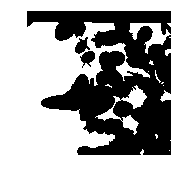

In [7]:
z = seeds[0][2]+0.3 # Cross section's z value
[ellipses, lines] = get_cross_section(vor, z, tau)

figure = save_cross_section(ellipses, lines, bounds, voxel_size, 'voronoi.png')


We can also generate all of our images with:

In [ ]:
voxelize(seeds,bounds,tau,voxel_size, 'voxels_z=')

From here you can go and slice these and (potentially) print a model.

But you might want to make sure the foam looks good...

#### Loading Voxels from images
It is not too difficult to load voxel data from images, and there is even an easy to use function to handle it in the most recent version of `matplotlib`.

In [28]:
# Here I'm using a previously rendered set of images
sorted_images = get_slice_filenames('voxel_renders_3/voxels_z=')
sorted_images = sorted_images[2:22]
voxels = load_voxels(sorted_images)

In [ ]:
draw_voxels(voxels)

Unfortunately, `matplotlib`'s voxel drawing capabilities are very slow - it is generating the geometry for each voxel as a new cube before displaying it. I'm not even going to try to visualize this foam (which is 400x600x20) using this function.

If we want something faster, we could draw the depth map:

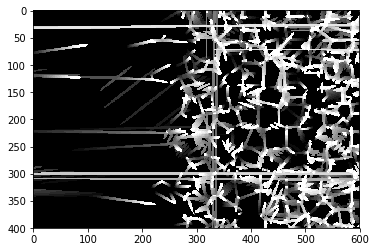

In [29]:
draw_depthmap(voxels)


### Conclusions so far
- Creating a Voronoi foam is harder than it looks
- The highly parallelizable algorithms in the paper are very slow on a CPU

#### Next steps
There are a number of logical steps to take after this:


1. Implement the algorithm on a GPU, which would solve a lot of the current problems. (make faster, fix issues with ellipses not perfectly representing line segments, etc.)
2. Marching cubes voxel to mesh conversion (for a slicer to immediately convert back to voxels before slicing...).
3. Frame generation - calculating where the foam intersects a mesh and figuring out an appropriate frame.
4. Actually print something...

# Just in Time Compiling with Numba

- Numba can compile Python code in 3 ways: (that are relevant to us)
    - `target=gpu` - sadly requires the purchase of NumbaPro and Anaconda Accelerate
    - `nopython` - results in a 10-50 times speedup
    - Object mode - Accesses python classes, which significantly slows down the code

- Finicky, but when it works, it is very simple
    - Compiles the first time it is called with a particular type of arguments 

In [15]:
from numba import jit

@jit(nopython=False)
def bisector_line(s1,s2,s3):
    '''Returns a line (pont on line, unit tangent) that is equidistance from these arguments.'''
    s1 = numpy.array(s1)
    s2 = numpy.array(s2)
    s3 = numpy.array(s3)
    axis = numpy.zeros(3)
    cross3(s1-s2, s1-s3, axis)
    if(axis[0]==0 and axis[1] == 0 and axis[2] == 0): # Axis is zero vector
        raise ValueError("Seeds are colinear")
    s_avg = (s1+s2+s3)/3 # Bisector line passes through here
    return (s_avg, axis)

p1 = np.array([1,2,3])
p2 = np.array([3,4,5])
p3 = np.array([6,7,10])
bisector_line(p1,p2,p3)

(array([ 3.33333333,  4.33333333,  6.        ]), array([ 4., -4.,  0.]))

# Marching cubes
- There is a marching cubes implementation in `scikit-image` that is very easy to use
    - There is apparently a faster, [possibly better](https://pyscience.wordpress.com/2014/09/11/surface-extraction-creating-a-mesh-from-pixel-data-using-python-and-vtk/) implementation in vtk, but it is slightly harder to use.
- It is easy enough to export to an `stl` format for consumption by Cura or other 3D printing program.

- Creates large models - the full set of voxels ($z \in [-10, 10]$) creates a 800Mb stl file.

In [27]:
# Both runs marching cubes, and saves as an stl
save_stl(voxels, 'foam.stl')

![Render of the foam.stl](./stl_render_voxel_renders_3_9s.png)

# Print something out!

![Image of the printing foam](print.jpg)